In [4]:
import os
print(os.listdir("../input/caltech101/101_objectcategories/101_ObjectCategories"))



['mayfly', 'menorah', 'ant', 'cannon', 'inline_skate', 'brontosaurus', 'flamingo', 'lamp', 'sea_horse', 'ewer', 'Faces_easy', 'stegosaurus', 'cellphone', 'car_side', 'bonsai', 'pyramid', 'octopus', 'brain', 'hawksbill', 'stapler', 'cup', 'buddha', 'dragonfly', 'yin_yang', 'crocodile_head', 'schooner', 'soccer_ball', 'elephant', 'anchor', 'scorpion', 'gramophone', 'garfield', 'electric_guitar', 'starfish', 'minaret', 'revolver', 'headphone', 'mandolin', 'snoopy', 'panda', 'hedgehog', 'sunflower', 'Faces', 'ceiling_fan', 'platypus', 'chair', 'euphonium', 'crocodile', 'pizza', 'trilobite', 'kangaroo', 'tick', 'water_lilly', 'ibis', 'joshua_tree', 'wrench', 'laptop', 'windsor_chair', 'helicopter', 'bass', 'scissors', 'Leopards', 'lobster', 'lotus', 'accordion', 'crayfish', 'dollar_bill', 'chandelier', 'gerenuk', 'butterfly', 'pagoda', 'saxophone', 'beaver', 'camera', 'binocular', 'Motorbikes', 'dolphin', 'airplanes', 'ferry', 'strawberry', 'cougar_body', 'wild_cat', 'umbrella', 'wheelchair

In [10]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

from keras import initializers
import tensorflow as tf
from keras import backend as K
K.common.image_dim_ordering()
#K.set_image_dim_ordering('th')

import os
import numpy as np
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt


def imread(path):
    img = scipy.misc.imread(path).astype(np.float)
    if len(img.shape) == 2:
        img = np.transpose(np.array([img, img, img]), (2, 0, 1))
    return img
    
path = "../input/caltech101/101_objectcategories/101_ObjectCategories"
#path = cwd + "/101_ObjectCategories"
valid_exts = [".jpg", ".gif", ".png", ".jpeg"]
print ("[%d] CATEGORIES ARE IN \n %s" % (len(os.listdir(path)), path))

categories = sorted(os.listdir(path))
ncategories = len(categories)
imgs = []
labels = []
# LOAD ALL IMAGES 
for i, category in enumerate(categories):
    iter = 0
    for f in os.listdir(path + "/" + category):
        if iter == 0:
            ext = os.path.splitext(f)[1]
            if ext.lower() not in valid_exts:
                continue
            fullpath = os.path.join(path + "/" + category, f)
            img = scipy.misc.imresize(imread(fullpath), [128,128, 3])
            img = img.astype('float32')
            img[:,:,0] -= 123.68
            img[:,:,1] -= 116.78
            img[:,:,2] -= 103.94
            imgs.append(img) # NORMALIZE IMAGE 
            label_curr = i
            labels.append(label_curr)
        #iter = (iter+1)%10;
print ("Num imgs: %d" % (len(imgs)))
print ("Num labels: %d" % (len(labels)) )
print (ncategories)

seed = 7
np.random.seed(seed)
import pandas as pd
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs, labels,test_size = 0.7)
X_train = np.stack(X_train, axis=0)
y_train = np.stack(y_train, axis=0)
X_test = np.stack(X_test, axis=0)
y_test = np.stack(y_test, axis=0)
print ("Num train_imgs: %d" % (len(X_train)))
print ("Num test_imgs: %d" % (len(X_test)))
# # one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes= y_test.shape[1]

print(y_test.shape)
print(X_train[1,1,1,:])
print(y_train[1])
# normalize inputs from 0-255 to 0.0-1.0
print(X_train.shape)
print(X_test.shape)
#X_train = X_train.transpose(0, 3, 1, 2)
#X_test = X_test.transpose(0, 3, 1, 2)
#print(X_train.shape)
#print(X_test.shape)

import scipy.io as sio
data = {}
data['categories'] = categories
data['X_train'] = X_train
data['y_train'] = y_train
data['X_test'] = X_test
data['y_test'] = y_test
sio.savemat('caltech_del.mat', data)

from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
# Create the model
model = Sequential()
# model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
# model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(64, (3, 3), input_shape=(128, 128, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))



[102] CATEGORIES ARE IN 
 ../input/caltech101/101_objectcategories/101_ObjectCategories


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Num imgs: 9144
Num labels: 9144
102
Num train_imgs: 2743
Num test_imgs: 6401
(6401, 102)
[-23.68  48.22  89.06]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
(2743, 128, 128, 3)
(6401, 128, 128, 3)


In [11]:
# Compile mode
epochs = 300
lrate = 0.0001
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
#adam = SGD(lr=0.0001)
#model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

np.random.seed(seed)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 256)      

In [12]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          epochs=epochs, batch_size=56, shuffle=True)
  #, callbacks=[earlyStopping]
#hist = model.load_weights('./64.15/model.h5');


Train on 2743 samples, validate on 6401 samples
Epoch 1/300
2743/2743 [==============================] - 17s 6ms/step - loss: 4.5973 - accuracy: 0.0270 - val_loss: 4.5633 - val_accuracy: 0.0864
Epoch 2/300
2743/2743 [==============================] - 15s 5ms/step - loss: 4.4970 - accuracy: 0.0817 - val_loss: 4.3127 - val_accuracy: 0.0865
Epoch 3/300
2743/2743 [==============================] - 15s 5ms/step - loss: 4.3388 - accuracy: 0.0926 - val_loss: 4.2478 - val_accuracy: 0.0865
Epoch 4/300
2743/2743 [==============================] - 15s 5ms/step - loss: 4.2757 - accuracy: 0.1083 - val_loss: 4.2031 - val_accuracy: 0.0865
Epoch 5/300
2743/2743 [==============================] - 15s 5ms/step - loss: 4.2544 - accuracy: 0.1083 - val_loss: 4.1759 - val_accuracy: 0.1030
Epoch 6/300
2743/2743 [==============================] - 15s 5ms/step - loss: 4.2158 - accuracy: 0.1188 - val_loss: 4.1588 - val_accuracy: 0.1347
Epoch 7/300
2743/2743 [==============================] - 15s 5ms/step - loss

2743/2743 [==============================] - 15s 5ms/step - loss: 2.8038 - accuracy: 0.3729 - val_loss: 2.9723 - val_accuracy: 0.3640
Epoch 57/300
2743/2743 [==============================] - 15s 5ms/step - loss: 2.7957 - accuracy: 0.3802 - val_loss: 2.9328 - val_accuracy: 0.3724
Epoch 58/300
2743/2743 [==============================] - 15s 5ms/step - loss: 2.6984 - accuracy: 0.3861 - val_loss: 2.9328 - val_accuracy: 0.3703
Epoch 59/300
2743/2743 [==============================] - 15s 5ms/step - loss: 2.7098 - accuracy: 0.3843 - val_loss: 2.9674 - val_accuracy: 0.3693
Epoch 60/300
2743/2743 [==============================] - 15s 5ms/step - loss: 2.6701 - accuracy: 0.3963 - val_loss: 2.9035 - val_accuracy: 0.3756
Epoch 61/300
2743/2743 [==============================] - 15s 5ms/step - loss: 2.6473 - accuracy: 0.4043 - val_loss: 2.9091 - val_accuracy: 0.3754
Epoch 62/300
2743/2743 [==============================] - 15s 5ms/step - loss: 2.5978 - accuracy: 0.4087 - val_loss: 2.8829 - val_a

Epoch 112/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.9993 - accuracy: 0.7251 - val_loss: 2.9525 - val_accuracy: 0.4396
Epoch 113/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.8949 - accuracy: 0.7528 - val_loss: 2.9893 - val_accuracy: 0.4370
Epoch 114/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.8859 - accuracy: 0.7554 - val_loss: 2.9096 - val_accuracy: 0.4335
Epoch 115/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.8557 - accuracy: 0.7619 - val_loss: 2.9742 - val_accuracy: 0.4384
Epoch 116/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.8353 - accuracy: 0.7656 - val_loss: 2.9368 - val_accuracy: 0.4438
Epoch 117/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.7929 - accuracy: 0.7838 - val_loss: 3.1229 - val_accuracy: 0.4438
Epoch 118/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.8010 - accuracy: 0.7838 - val_

2743/2743 [==============================] - 15s 5ms/step - loss: 0.2130 - accuracy: 0.9402 - val_loss: 3.7296 - val_accuracy: 0.4468
Epoch 168/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.2354 - accuracy: 0.9289 - val_loss: 3.8212 - val_accuracy: 0.4465
Epoch 169/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.2151 - accuracy: 0.9340 - val_loss: 3.8109 - val_accuracy: 0.4502
Epoch 170/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.2228 - accuracy: 0.9369 - val_loss: 3.9088 - val_accuracy: 0.4479
Epoch 171/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.2059 - accuracy: 0.9355 - val_loss: 4.1254 - val_accuracy: 0.4460
Epoch 172/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.2116 - accuracy: 0.9398 - val_loss: 3.9729 - val_accuracy: 0.4496
Epoch 173/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.2124 - accuracy: 0.9402 - val_loss: 4.2082 -

2743/2743 [==============================] - 15s 5ms/step - loss: 0.0982 - accuracy: 0.9719 - val_loss: 4.4112 - val_accuracy: 0.4501
Epoch 223/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.1097 - accuracy: 0.9679 - val_loss: 4.2287 - val_accuracy: 0.4481
Epoch 224/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.1246 - accuracy: 0.9668 - val_loss: 4.1958 - val_accuracy: 0.4507
Epoch 225/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.0888 - accuracy: 0.9745 - val_loss: 4.3284 - val_accuracy: 0.4531
Epoch 226/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.0938 - accuracy: 0.9708 - val_loss: 4.5361 - val_accuracy: 0.4496
Epoch 227/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.0763 - accuracy: 0.9789 - val_loss: 4.4223 - val_accuracy: 0.4495
Epoch 228/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.0599 - accuracy: 0.9814 - val_loss: 4.5942 -

2743/2743 [==============================] - 15s 6ms/step - loss: 0.0764 - accuracy: 0.9785 - val_loss: 4.3549 - val_accuracy: 0.4562
Epoch 278/300
2743/2743 [==============================] - 15s 6ms/step - loss: 0.0576 - accuracy: 0.9865 - val_loss: 4.4594 - val_accuracy: 0.4576
Epoch 279/300
2743/2743 [==============================] - 15s 6ms/step - loss: 0.0445 - accuracy: 0.9865 - val_loss: 4.5350 - val_accuracy: 0.4543
Epoch 280/300
2743/2743 [==============================] - 15s 6ms/step - loss: 0.0434 - accuracy: 0.9872 - val_loss: 4.5116 - val_accuracy: 0.4515
Epoch 281/300
2743/2743 [==============================] - 15s 5ms/step - loss: 0.0495 - accuracy: 0.9883 - val_loss: 4.5979 - val_accuracy: 0.4551
Epoch 282/300
2743/2743 [==============================] - 15s 6ms/step - loss: 0.0388 - accuracy: 0.9880 - val_loss: 4.7040 - val_accuracy: 0.4535
Epoch 283/300
2743/2743 [==============================] - 15s 6ms/step - loss: 0.0461 - accuracy: 0.9861 - val_loss: 4.6665 -

Accuracy: 45.40%


KeyError: 'acc'

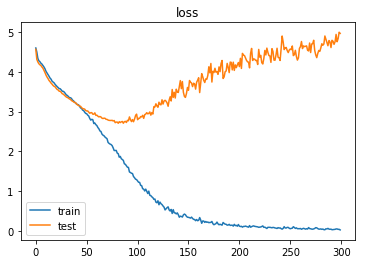

<Figure size 432x288 with 0 Axes>

In [13]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train','test'])
plt.title('loss')
plt.savefig("loss7.png",dpi=300,format="png")
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train','test'])
plt.title('accuracy')
plt.savefig("accuracy7.png",dpi=300,format="png")
model_json = model.to_json()
with open("model7.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model7.h5")
print("Saved model to disk")

In [ ]:
!pip install keras==2.2.4


In [ ]:
!pip install tensorflow-gpu==1.13.1
